<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Basic_Temporal_Supervised_Machine_Learning_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning for Time Series Data
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Determine the probability of rain some number of hours in the future based on the last X hours of collected data across six features.

This notebook shows how to take advantage of the information contained in sequences from time series data.  It shows how to convert time series data into dataframes useful for supervised machine learning. 

Additionally, this notebook shows how to:
1.  Follow a managed workflow from Data to Verification.  This uses GitHub, Google Drive, and Tensorboard to demonstrate what a production workflow might look like.
2.  Connect a Keras/Tensorflow model with SKLearn and Pandas tools
3.  Use Tensorboard for Evaluating models

## Learning Objectives


* Evaluate why time series data is interesting and useful for prediction.
* Learn techniques for unrolling sequences and building a supervised learning dataset from time series data.
* Learn techniques for shifting labels to enable predictions of future states using current data.
* Demonstrate real-time inference using new data.

## Dataset

This dataset is the famous "Tod Newman Back Porch" Dataset.  See http://www.todnewman.com for details on the data collection system.

Features include:
* Distance of Lightning Strike (km)
* Energy of Lightning Strike (unitless)
* Visible Light Luminosity (lux)
* Humidity (%)
* Pressure (HPa)
* Temperature (deg F)

The Label is:
* Rain: Was it raining during the collection interval or not.





In [0]:
import os, sys 
sys.path.insert(0, os.getcwd()) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
tensorboard = False



# Data

Below I demonstrate a number of different approaches to getting data into our processing pipeline.  I mostly load data and common python modules from my GitHub account (https://github.com/todnewman).  I tend to store models and other artifacts of this workflow in my Google Drive.  When using this workflow, the developer will of course read from and save to their own Google Drive.  You'll need a Google account (which you probably need anyway to use this Notebook) and would have to authenticate.  That is all handled in number 2 below.

Right now this workflow is automated and the products are very available.  This is very useful for using as training modules.

##Methods of Data Insertion:
1. Direct import from your PC local storage
2. Load from Google Drive 
3. Load from GitHub
4. Direct acquisition from repositories (like UC Irvine's Open Data Repository).  Use wget or import a URL directly in to pandas read_csv().

### Here's how you can load files to and from YOUR Google Drive.  

It will give you a link to follow which will ask you to log in to your Google account.  Then your Google drive will show up as /content/drive/'My Drive'

This is a good way to get larger datafiles into your workflows.  They'll take up space on your Google Drive, but you have 15GB for free.

If you want to grab tod's lightning_sensor_data.csv, it is public and accessible at this link:  https://drive.google.com/file/d/12rb8lkz16iTWuvB2OVXwZ0SJvE8AYSps/view?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/models
%ls
%cp rain_model_mlp /content/rain_model_mlp

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/models
cnn_fashion_mnist          model_n17.hdf5
id_model                   ngrok
lanl_lstm_model            ngrok-stable-linux-amd64.zip
LANL_new_model             ngrok-stable-linux-amd64.zip.1
LANL_new_model.05          quake_model_mlp
lanl_quake_lstm            quake_model_mlp.41
lanl_quake_lstm.1          quake_model_mlp.75
lanl_quake_lstm150         quake_model_mlp.bak
lanl_quake_lstm.2          quake_model_mlp_done
log/          

### Loading data from GitHub

Here's another really good way to get example data in.  I have a data project in GitHub that is associated with the coe_training project.  We can download the whole folder with the git clone command or just one file with the wget command.

In [2]:
%cd /content
# Below is how you clone the whole data project from Tod's GitHub
#!git clone https://github.com/todnewman/data
# Below is how you can grab just the single .csv file for this project.  You can get this address by clicking on a file, then clicking 'RAW'
#  in GitHub.  Then copy the link address from the browser.
!wget -O /content/lightning_sensor_data.csv 'https://raw.githubusercontent.com/todnewman/data/master/lightning_sensor_data.csv'
!wget -O /content/lightning_sensor_data_predict.csv 'https://raw.githubusercontent.com/todnewman/data/master/lightning_sensor_data_predict.csv'
!wget -O /content/pytools.py 'https://raw.githubusercontent.com/todnewman/coe_training/master/pytools.py'
import pytools


/content
--2019-06-11 01:03:27--  https://raw.githubusercontent.com/todnewman/data/master/lightning_sensor_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430262 (420K) [text/plain]
Saving to: ‘/content/lightning_sensor_data.csv’

/content/lightning_ 100%[===================>] 420.18K  --.-KB/s    in 0.04s   

2019-06-11 01:03:27 (9.64 MB/s) - ‘/content/lightning_sensor_data.csv’ saved [430262/430262]

--2019-06-11 01:03:28--  https://raw.githubusercontent.com/todnewman/data/master/lightning_sensor_data_predict.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awai

## Connect Tensorboard

Note that this gives a link to the Tensorboard URL at the end.  Train the model first and then click the  link below (will have ngrok.io at the end) to see results in Tensorboard.

Here's alink with basic info on Tensorboard:  https://www.tensorflow.org/guide/summaries_and_tensorboard

In [2]:
if not tensorboard:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

    
tensorboard = True

--2019-06-11 00:58:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.145.207, 34.206.253.53, 52.204.136.9, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  15.88M  44.6MB/s    in 0.4s    

2019-06-11 00:58:13 (44.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   
https://a37c73d7.ngrok.io


## Split Data into Training and Test Sets
This function takes a dataframe, the size of the test set in percentage of the whole, a randomizing seed, and the target column number as arguments.
First we capture the target column to prevent it from being scaled by the scaler.
Then, we convert the data (X) into numpy arrays and scale.  There are three scalers that are effective for this work.  MaxAbsScaler is better with sparse data.
Finally, we use Python sklearn's train_test_split function to return X and y for training and X and y for test.


In [0]:
def split_data(df, size, predict_flag, target):
    ''' Split the data into training and testing sets.  Column headers below are custom for the "Douglas data set".
    NaN's are filled with zero to maintain consistent data shapes.
    '''
    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing
    from imblearn.combine import SMOTEENN
    from imblearn.over_sampling import ADASYN
    
    df = df.convert_objects(convert_numeric=True).fillna(0)
    
    y = df.pop(target) # Remove the 'target' column that has the labels
    y = np.array(y).astype(int) # in case the target is a float for some reason
    X = df.fillna(0)    
    
    #  Scale the data.  This allows many of the algorithms to work more effectively
 
    X = preprocessing.MinMaxScaler().fit_transform(X)
    X = np.array(X)
    
    
    
    if predict_flag:
        return X, y
    else:
        # Scale the data so it works better with the ML algorithms
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=size) # Keeping the test set small to evaluate timing
        #X_train = tf.convert_to_tensor(X_train)
        print("X_train size: {}".format(X_train.shape))
        print("y_train size: {}".format(y_train.shape))
        print("X_test size: {}".format(X_test.shape))
        print("y_test size: {}".format(y_test.shape))
        
        #sm = ADASYN(random_state=41)
        sm = SMOTEENN(random_state=41)
        X_train, y_train = sm.fit_sample(X_train, y_train) # This just oversamples the training set.    
        return X_train, X_test, y_train, y_test

## Create Multi-Layer Perceptron network for this problem

We're designing this MLP network to work with our data shape.  Adding a Leaky RELU activation function and Dropout to control for overfitting.  Classification layer is a dense layer size one since we're only doing binary classification.

* It may be interesting to play with the dropout parameters.  Sometimes I see better performance when dropout is higher at lower layer numbers and vice versa.
* The Leaky Relu does really seem to be advantageous.  What is the optimal alpha parameter?  See here:  https://keras.io/layers/advanced-activations/
* There are lots and lots of metrics to choose.  Maybe accuracy isn't always the best.  What other metrics (and loss functions) might be useful?  https://keras.io/metrics/

In [0]:
def nn_mlp(input_shape, learning_rate):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape[1]))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.4))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.4))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(lr=learning_rate)
    model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

## Process Data and execute shift_time function in order to create temporal supervised ML model.

Shift_time essentially takes the 'shift_depth' number of previous sequences for each feature and makes new features out of them.  This flattens the record with new_features = orig_number_of_features * shift_depth

Then shift_time takes the target vector and shifts the future target 'y_shift' sequences away into the record.  

What this allows is one large record with the current samples of each feature, some number of previous samples for each feature (shift_depth number) and the target value from the future.

In the case of this example, this allows us to use the shift_depth previous sequences of environmental data to predict whether it will be raining y_shift hours in the future.

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


X_train size: (2774, 48)
y_train size: (2774,)
X_test size: (1850, 48)
y_test size: (1850,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Fitting the Model.  See time below:
Instructions for updating:
Use tf.cast instead.
1850/1850 [==============================] - 0s 11us/step
[0.028342434278304462, 0.9691891886092521]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2

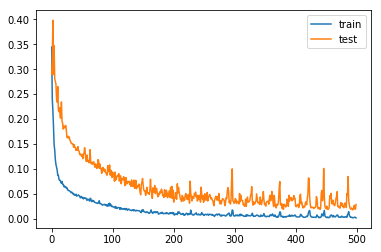

Report that scores the ability of the model to predict the target on the test data:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1792
           1       0.84      0.79      0.81        58

    accuracy                           0.99      1850
   macro avg       0.91      0.89      0.90      1850
weighted avg       0.99      0.99      0.99      1850

Cohen-Kappa Score:    0.81


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


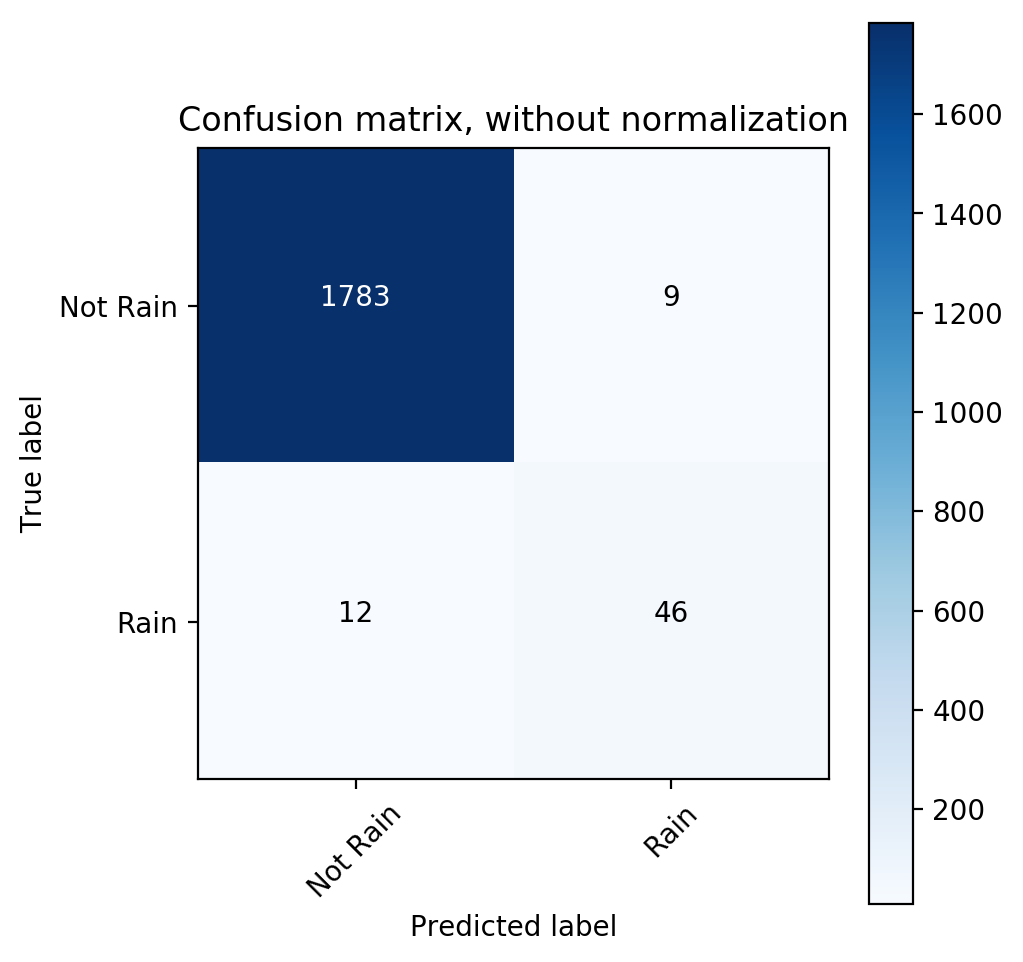

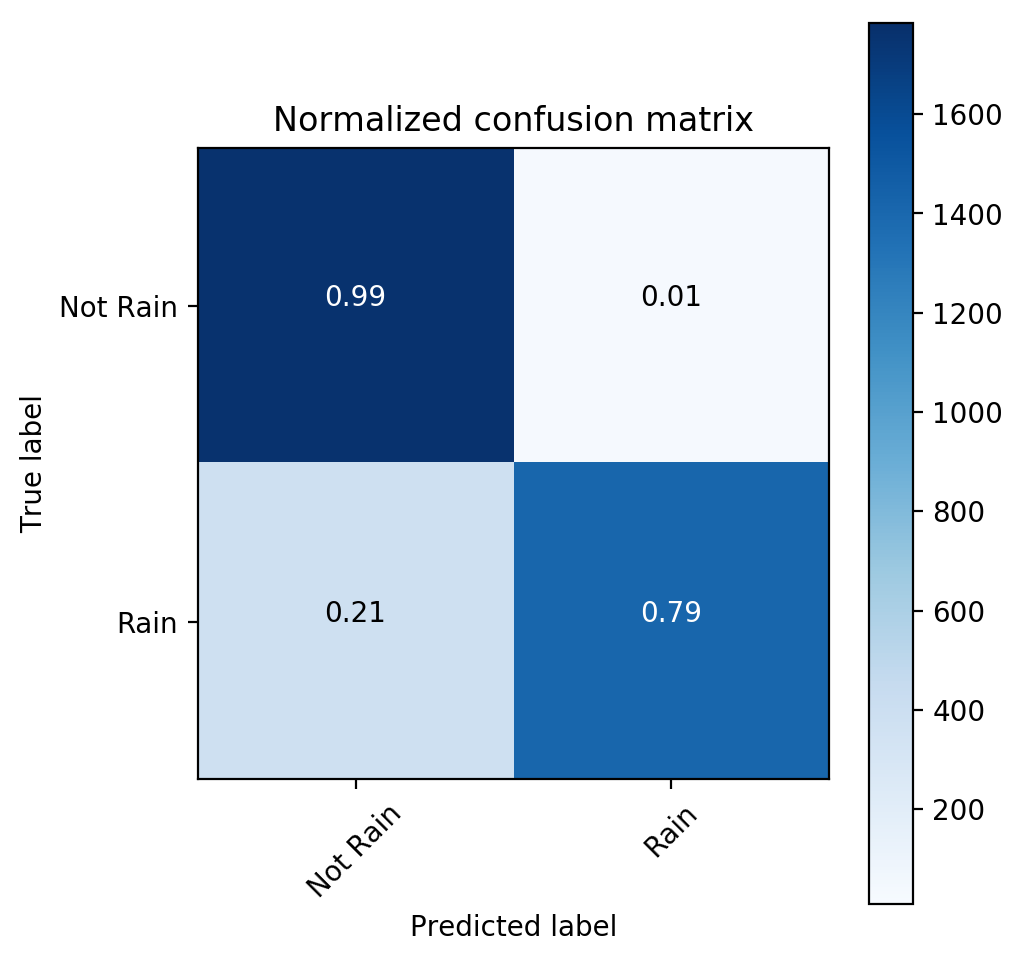

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM, Flatten, Dense, Activation, Dropout, MaxPooling1D
from keras.models import Sequential
from sklearn.metrics import cohen_kappa_score
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers
from numpy import concatenate
from math import sqrt
from keras.callbacks import TensorBoard
import pytools

target = 'Rain'
num_epochs = 500
batch_size = 64
shift_depth = 8 # The number of previous observations to use as features
learning_rate = .001
y_shift = -12  # Shift the target so we're predicting events in the future.  In this case, 12 hours.

weights_file = 'rain_model_mlp'
reuse_trained_model = False

df = pd.read_csv('/content/lightning_sensor_data.csv', error_bad_lines=False)

# convert series to supervised learning.  This is a sneaky trick that simplifies
# data preparation by creating new features comprised of a sequence of features.
# The number of features goes up when you do that by a factor of shift_depth.
# We pull the label (df_y) out beforehand though, so past sequences of the label
# don't get pulled in.

def shift_time(data, df_y,  n_in=1,  y_shift=6, dropnan=True):
    """
	  Frame a time series as a supervised learning dataset.
	  Arguments:
		  data: Sequence of observations as a list or NumPy array.
		  n_in: Number of lag observations as input (X).
		  dropnan: Boolean whether or not to drop rows with NaN values.
	  Returns:
		  Pandas DataFrame of series framed for supervised learning.
	  """
    df_y_copy = df_y
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    # This is where we select a sequence of data as features.
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    #  Here's where we shift our label.  My goal is to predict rain 12 hours in
    #  the future using the last 8 values in the sequence for each of the X features.
    y_len = df_y.shape[0]
    df_y = df_y.shift(periods=y_shift).fillna(0)
    df_y = df_y.drop(df_y.index[y_len-y_shift:y_len])
    
              
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg_len = agg.shape[0]
    agg = agg.drop(agg.index[agg_len-y_shift:agg_len])
    agg.columns = names
    
    # drop rows with NaN values
    
    if dropnan:
        agg.dropna(inplace=True)
        
    agg = agg.reset_index(drop=True)
    agg['Rain'] = df_y
    return (agg)
      
#selecting only the column that we are going to use in the prediction process
data_to_use=df[['Full Light Spectrum', 'Humidity (%)', 'IR Spectrum', 'Luminosity (lux)', 'Pressure (HP-900)', 'Temperature (deg F)', 'Rain']]

# load dataset
y = data_to_use.pop('Rain')
dataset = data_to_use
values = dataset.values

# frame as supervised learning
reframed = shift_time(values, y, shift_depth, y_shift)
reframed['Rain'] = y

reframed.to_csv("/content/reframed.csv")

# split into train and test sets

train_X, test_X, train_y, test_y = split_data(reframed, 0.40, False, target) # Predict_flag = False

# design network

model = nn_mlp(train_X.shape, learning_rate)
if reuse_trained_model:
    model.load_weights(weights_file) 
# fit network
print()
print("Fitting the Model.  See time below:")

# Call TensorBoard for visual metrics
if tensorboard:
    tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                             write_graph=True,
                             write_grads=True,
                             batch_size=batch_size,
                             write_images=True)

# Fit the model based on everything we've defined to date.  Write metrics to 
# TensorBoard
if tensorboard:
    history = model.fit(train_X, train_y,            
                              batch_size=batch_size,
                              epochs=num_epochs,
                              verbose=1,
                              validation_data=(test_X, test_y), 
                              callbacks=[tbCallBack],
                              shuffle = False) 
else:
    history = model.fit(train_X, train_y,            
                              batch_size=batch_size,
                              epochs=num_epochs,
                              verbose=False,
                              validation_data=(test_X, test_y),                               
                              shuffle = False) 


score = model.evaluate(test_X, test_y, batch_size=batch_size)
print(score)
print(history)
print(model.summary())

model.save_weights(weights_file, overwrite=True)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


df_out = pd.DataFrame()
# make a prediction
yhat = model.predict(test_X)
df_out['yhat'] = pd.Series(yhat.flatten())
df_out['y'] = test_y

print("Report that scores the ability of the model to predict the target on the test data:\n")

yhat_int = df_out['yhat'].astype(int)
print(metrics.classification_report(test_y, yhat_int))

# The Kappa statistic (or value) is a metric that compares an Observed Accuracy with an 
# Expected Accuracy (random chance).  The kappa statistic can range between -1 and 1. 
# The maximum value means complete agreement; zero or lower means chance agreement.

ck_score = cohen_kappa_score(test_y, yhat_int)
print("Cohen-Kappa Score: %7.2f" % ck_score)

# Confusion Matrix

class_names = [ 'Not Rain', 'Rain']
pytools.call_confusion_matrix(test_y,yhat_int, class_names, 'rain_confusion_matrix.png', 5)


## Save trained Model for future use

Need to have the Google Drive loaded (see above)

In [6]:
%cd /content
%ls
#%cp reframed.csv /content/drive/'My Drive'/reframed.csv
%cp rain_model_mlp /content/drive/'My Drive'/models/rain_model_mlp

/content
1_rain_confusion_matrix.png        ngrok-stable-linux-amd64.zip
2_rain_confusion_matrix.png        ngrok-stable-linux-amd64.zip.1
drive/                             __pycache__/
lightning_sensor_data.csv          pytools.py
lightning_sensor_data_predict.csv  rain_model_mlp
log/                               reframed.csv
ngrok*                             sample_data/


# Predict New Data

We're going to load our saved model first.

(193, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


(185, 48)
<class 'numpy.ndarray'>


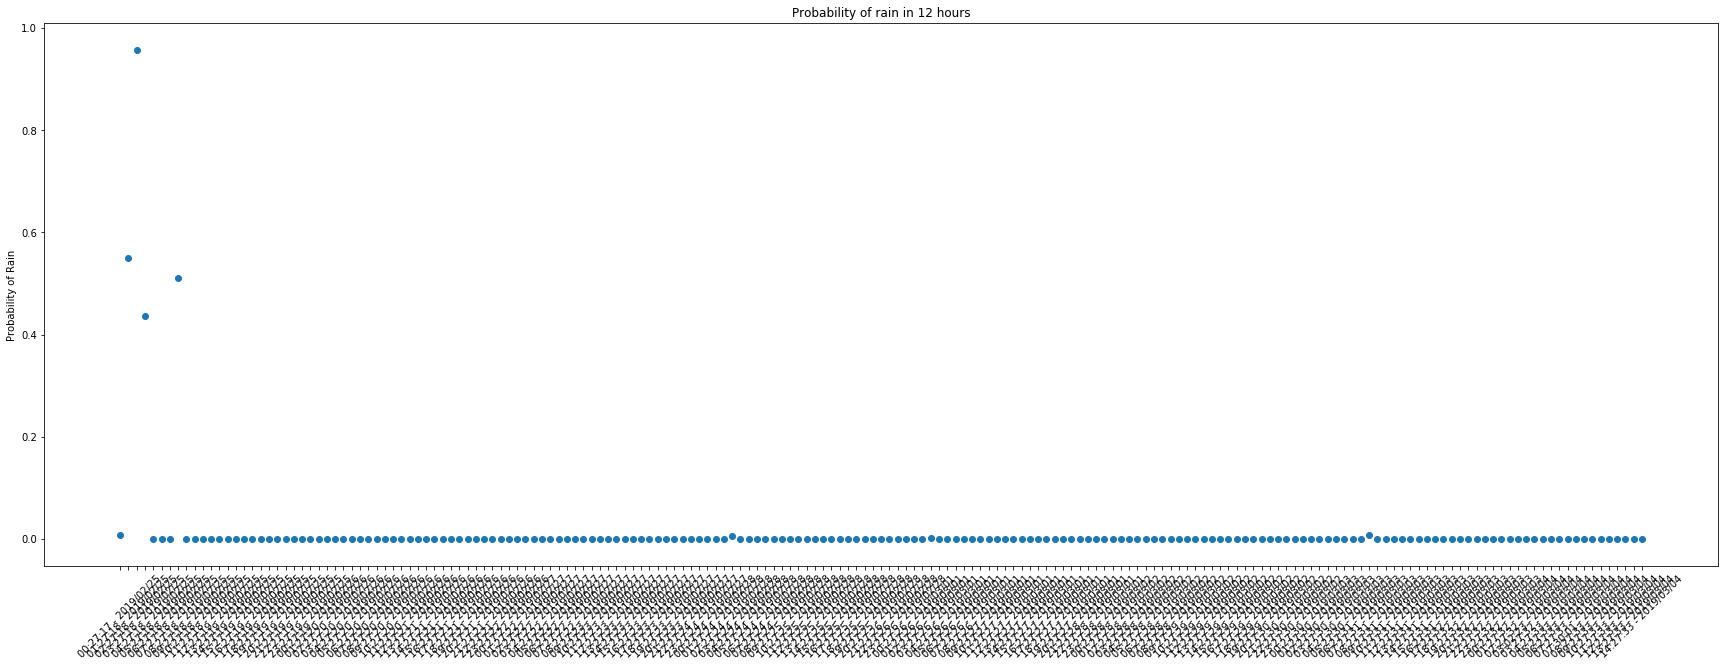

In [7]:
weights_file = 'rain_model_mlp'
model.load_weights(weights_file)
df1 = pd.read_csv('/content/lightning_sensor_data_predict.csv', error_bad_lines=False)
print(df1.shape)

df_time = df1['Time']

data_to_use1=df1[['Full Light Spectrum', 'Humidity (%)', 'IR Spectrum', 'Luminosity (lux)', 'Pressure (HP-900)', 'Temperature (deg F)']]

dataset = data_to_use1
dataset['Rain'] = 0
y = dataset.pop('Rain')

#print(dataset)
values = dataset.values

# frame as supervised learning

reframed = shift_time(values, y, shift_depth, y_shift)



#print(reframed)

predict_X, y_bogus = split_data(reframed, 0.30, True, target) # Predict_flag = False

# reshape input to be 3D [samples, timesteps, features]

print(predict_X.shape)

probs = model.predict_proba(predict_X)
print (type(probs))
df_t = pd.Series(df_time[0:predict_X.shape[0]])

#df_pred = reframed.copy()
df_pred = pd.DataFrame()
df_pred['Time'] = df_t

#df_pred['Predicted Value'] = (predict_val[0:])
df_pred['Predicted Probability of Rain'] = probs

#df_pred.to_csv(out_filename)
k = df_pred.keys()

#df_pred.sort_values(['Predicted Value'], ascending=[False])

plt.figure( figsize=(30,10))
plt.title("Probability of rain in 12 hours")
plt.ylabel("Probability of Rain")
plt.scatter(df_pred[k[0]], df_pred[k[1]], label="Probability of Rain in 12 hours")
plt.xticks(rotation=45)
plt.show()